NB! Don't run this notebook unless you have a GPU on your computer; it executes slowly on a CPU.

# VAE analysis of two lung cancer sets

Here we train a VAE on two different datasets from TCGA. We will first merge the two datasets and subsequently try to separate the samples based on their latent variables. This is made analogous to the notebook on PCA.

First we retrieve our two TCGA lung cancer datasets from cbioportal.org. One of the sets is from [Lung Adenocarcinomas](https://en.wikipedia.org/wiki/Adenocarcinoma_of_the_lung) and the other is from [Lung Squamous Cell Carcinomas](https://en.wikipedia.org/wiki/Squamous-cell_carcinoma_of_the_lung). We first load our datasets; the loading code is hidden here, but it is available in the module tcga_read.

Particularly, we added code that is hidden in the other version of the notebook,that is not important for the understanding of the analysis, but can be found in the module tcga_read. Execute the code and proceed to next step.

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ![ ! -f "dsbook/README.md" ] && git clone https://github.com/statisticalbiotechnology/dsbook.git
    my_path = "dsbook/dsbook/common/"
else:
    my_path = "../common/"
sys.path.append(my_path) # Read local modules for tcga access and qvalue calculations
import load_tcga as tcga

luad = tcga.get_expression_data(my_path + "../data/luad_tcga_pan_can_atlas_2018.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/luad_tcga_pan_can_atlas_2018.tar.gz',"data_mrna_seq_v2_rsem.txt")
lusc = tcga.get_expression_data(my_path + "../data/lusc_tcga_pan_can_atlas_2018.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/lusc_tcga_pan_can_atlas_2018.tar.gz',"data_mrna_seq_v2_rsem.txt")

File extracted to ../data/luad_tcga_pan_can_atlas_2018
File extracted to ../data/lusc_tcga_pan_can_atlas_2018


We now merge the datasets, and ensure that we only include transcripts that are measured in all samples with counts greater than zero. Subsequently we log our data and reduce our set to the 1k transcripts with highest variance. Further we scale the measurements so that every gene expression value is scaled using scikit-learn's StandardScaler.

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined = pd.concat([lusc[lusc.index.notna()] , luad[luad.index.notna()]], axis=1, sort=False)
# Drop rows with any missing values
combined.dropna(axis=0, how='any', inplace=True)
combined = combined.loc[~(combined<=0.0).any(axis=1)]
combined.index = combined.index.astype(str)
log_combined = np.log2(combined)
var = log_combined.var(axis=1)
top_k = 1000
top_genes = var.nlargest(top_k).index

log_combined = log_combined.loc[top_genes]
scaler = StandardScaler()
X = scaler.fit_transform(log_combined.T).astype(np.float32)
combined_reduced = pd.DataFrame(
    data=X.T,
    index=log_combined.index,
    columns=log_combined.columns,
)

We are setting up an instance of a machine learning framework, [PyTorch](https://en.wikipedia.org/wiki/PyTorch). It will help us fit the neural network. We also define a DataLoader that will help us load the data for processing in the tensor library, torch.

In [19]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import numpy as np

# Setting training parameters
batch_size, lr, epochs, log_interval = 256, 1e-3, 501, 100
hidden_dim, latent_dim = 512, 12

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(4711)
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}


# Convert combined DataFrame to a PyTorch tensor
datapoints = torch.tensor(combined_reduced.to_numpy().T, dtype=torch.float32)
input_dim = datapoints.shape[1]
labels = torch.tensor([1.0 for _ in lusc.columns] + [0.0 for _ in luad.columns], dtype=torch.float32)

# Use TensorDataset to create a dataset
dataset = TensorDataset(datapoints, labels)

# DataLoader for batching the data
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, **kwargs)

Now we design the VAE. We use an architecture where ~13k features are first reduced to a lower number of hidden features (fc1) and then to 12 features, for which we predict both mean and variance (fc21 and fc22). We reparameterize those 12 variables, and then expand them to a larger number of hidden nodes (fc3) and back to the original feature dimension (fc4).
![](img/nn.svg)

In [20]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)       # Input layer of encoder
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # Output layer encoder (mean)
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # Output layer encoder (stdv)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)  # Input layer of decoder
        self.fc4 = nn.Linear(hidden_dim, input_dim)       # Output layer of decoder

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)         # Dividing a logged value by two results in the log of the sqrt of the value 
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        out = self.fc4(h3)   
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Next, we select a gradient-based optimizer (Adam) and the loss function to optimize (reconstruction + KLD). The train and test procedures are defined below.

In [21]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # reconstruction per feature
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL per sample, then mean
    kl_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kld = kl_per_sample.mean()

    return recon_loss + beta * kld, recon_loss.item(), kld.item()

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device, non_blocking=True)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kld = loss_function(recon_batch, data, mu, logvar, beta=1.0)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if epoch % log_interval == 0:
            print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    with torch.no_grad():
        X_tensor = datapoints.to(device)
        x_hat_, mu_, logvar_ = model(X_tensor)
    x_hat = x_hat_.cpu().numpy()
    z = mu_.cpu().numpy()
    std = torch.exp(0.5 * logvar_).cpu().numpy()

Now we are set to run the procedure for 500 epochs.

In [22]:
for epoch in range(epochs):
    train(epoch)
test(epoch)

====> Epoch: 0 Average loss: 0.0015
====> Epoch: 0 Average loss: 0.0036
====> Epoch: 0 Average loss: 0.0051
====> Epoch: 0 Average loss: 0.0067
====> Epoch: 100 Average loss: 0.0010
====> Epoch: 100 Average loss: 0.0020
====> Epoch: 100 Average loss: 0.0030
====> Epoch: 100 Average loss: 0.0040
====> Epoch: 200 Average loss: 0.0010
====> Epoch: 200 Average loss: 0.0020
====> Epoch: 200 Average loss: 0.0031
====> Epoch: 200 Average loss: 0.0040
====> Epoch: 300 Average loss: 0.0010
====> Epoch: 300 Average loss: 0.0020
====> Epoch: 300 Average loss: 0.0030
====> Epoch: 300 Average loss: 0.0040
====> Epoch: 400 Average loss: 0.0010
====> Epoch: 400 Average loss: 0.0020
====> Epoch: 400 Average loss: 0.0030
====> Epoch: 400 Average loss: 0.0040
====> Epoch: 500 Average loss: 0.0010
====> Epoch: 500 Average loss: 0.0020
====> Epoch: 500 Average loss: 0.0030
====> Epoch: 500 Average loss: 0.0040


Note that we for this dataset have chosen to not use an independent testset. We have now trained our VAE. We can first evaluate it for the datapoints we trained it on, and get their embeddings in a vector, $z$.

In [23]:
model.eval()

x_batch, z_batch, std_batch = [], [], []
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.to(device)

        x_hat_, mean_, log_var = model(x)
        x_batch.append(x_hat_.cpu().detach().numpy())
        z_batch.append(mean_.cpu().detach().numpy())
        std_batch.append(torch.exp(log_var * 0.5).cpu().detach().numpy())

x_hat = np.concatenate(x_batch, axis=0)
z = np.concatenate(z_batch, axis=0)
std = np.concatenate(std_batch, axis=0)

We can now use the embeddings to describe our data. We first plot the differences between the different latent variables for the two datasets.

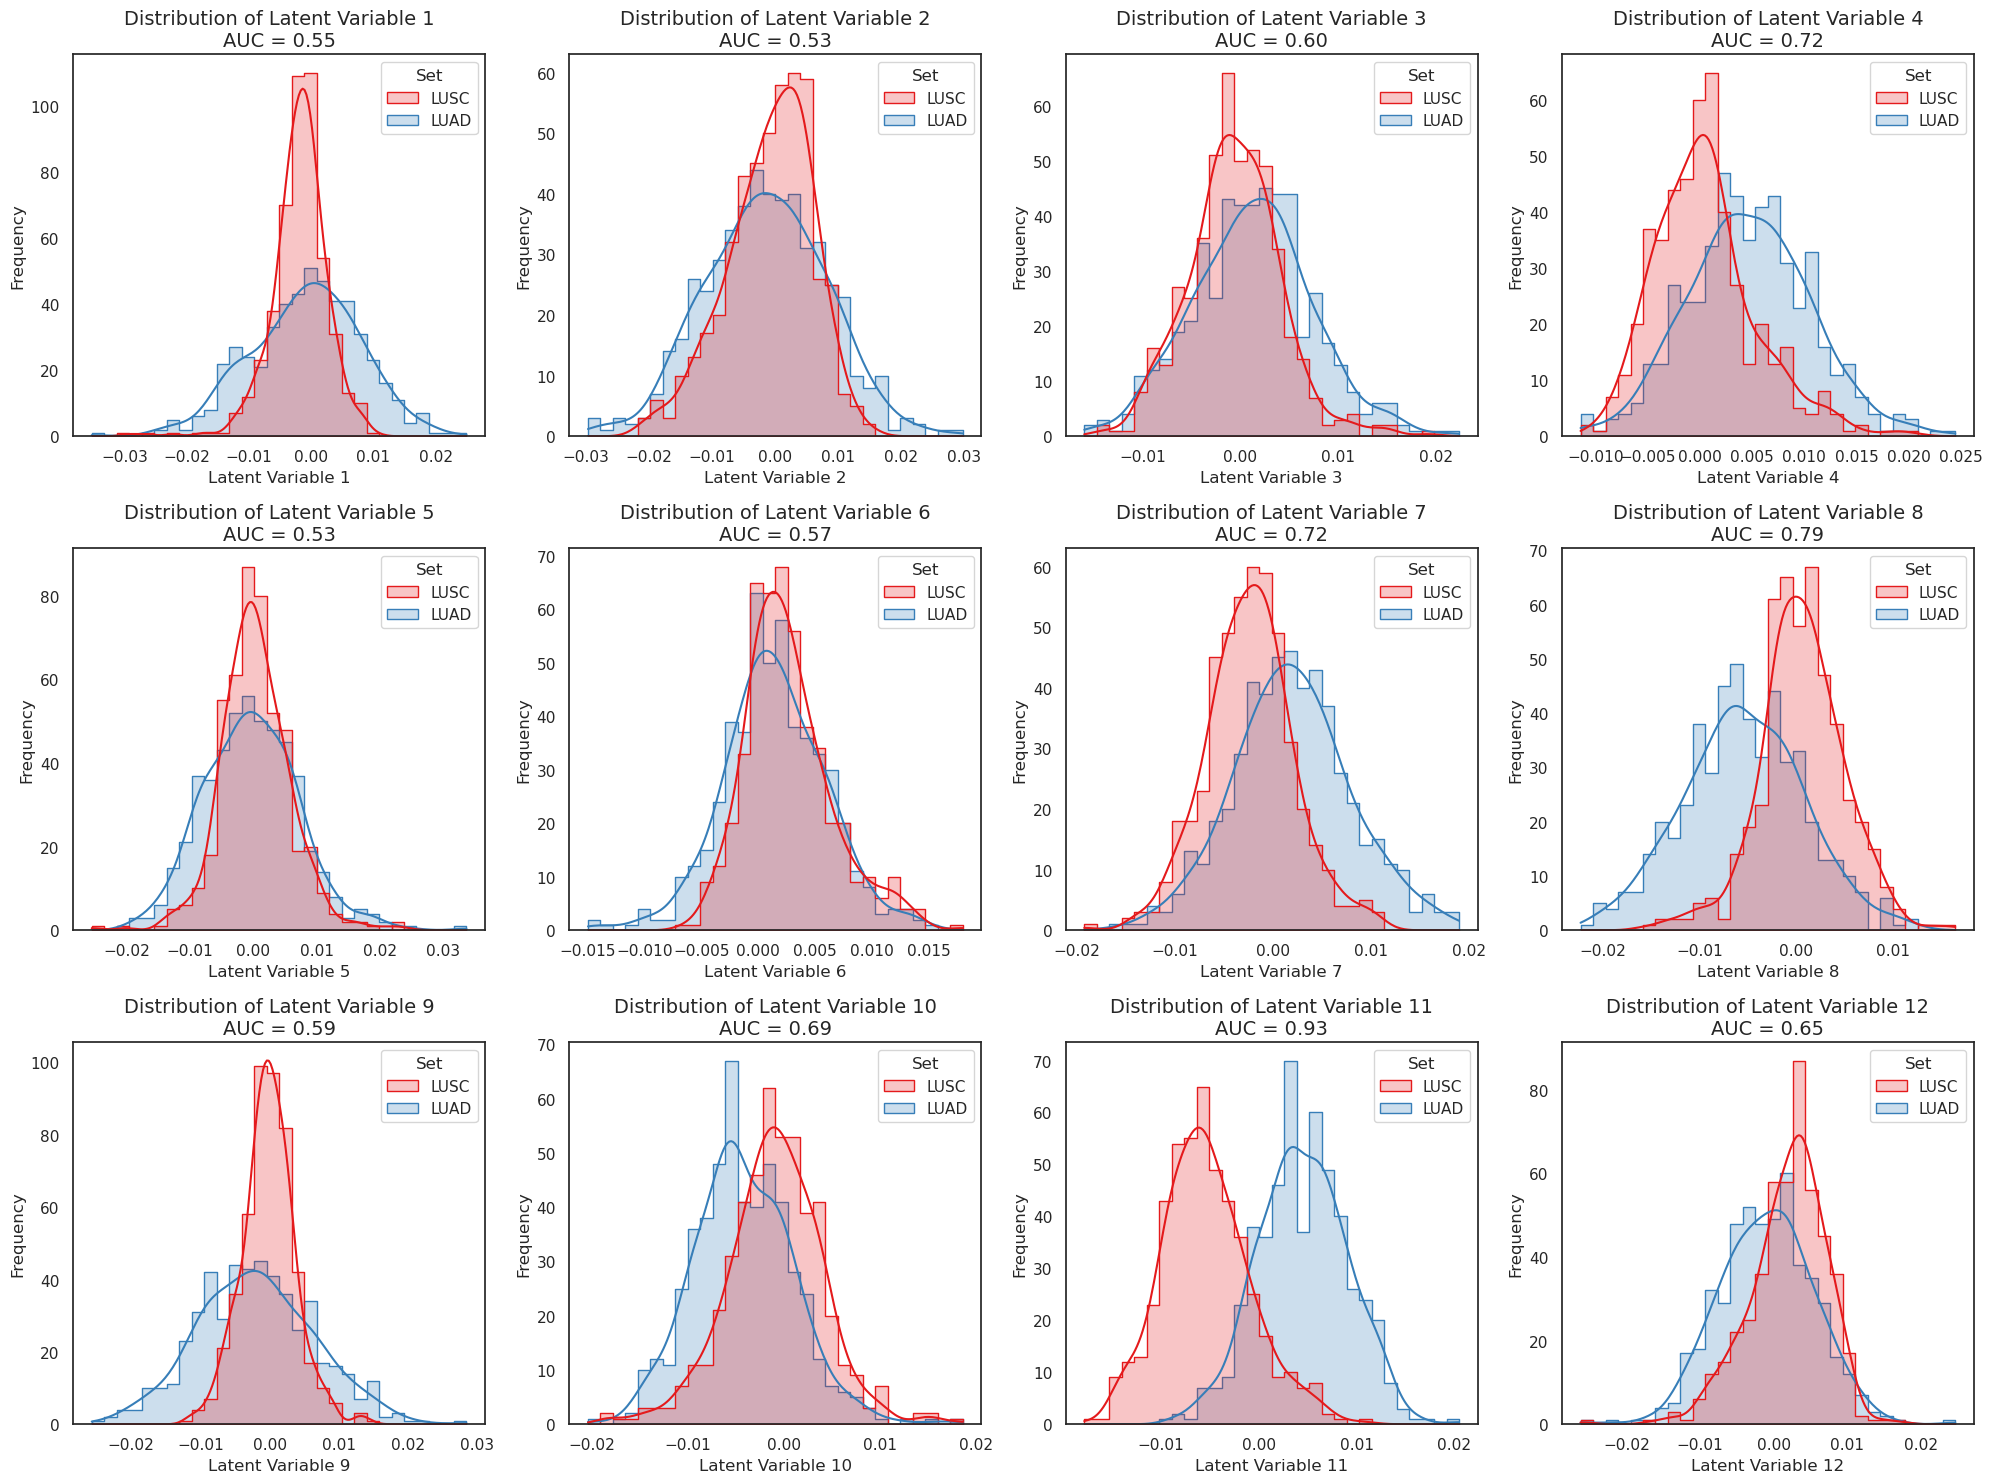

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# Create DataFrame for transformed patients
transformed_patients = pd.DataFrame(
    data=z,
    columns=[f"Latent Variable {ix+1}" for ix in range(latent_dim)],
    index=list(lusc.columns) + list(luad.columns)
)
transformed_patients["Set"] = ["LUSC" for _ in lusc.columns] + ["LUAD" for _ in luad.columns]
transformed_patients["Label"] = [1 for _ in lusc.columns] + [0 for _ in luad.columns]  # Assign numerical labels for AUC calculation

# Set Seaborn plotting style
sns.set(style="white", rc={"axes.titlesize": 14, "axes.labelsize": 12})

# Determine grid size
plots_per_row = 4
n_rows = int(np.ceil(latent_dim / plots_per_row))

# Create subplots
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Plot each latent variable's histogram and calculate AUC
for i in range(latent_dim):
    latent_variable_name = f"Latent Variable {i+1}"
    
    # Calculate AUC for the current latent variable
    auc = roc_auc_score(transformed_patients["Label"], transformed_patients[latent_variable_name])
    auc = max(auc, 1-auc)
    
    # Plot histogram
    sns.histplot(
        data=transformed_patients,
        x=latent_variable_name,
        hue="Set",
        kde=True,
        element="step",
        bins=30,
        palette="Set1",
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {latent_variable_name}\nAUC = {auc:.2f}")
    axes[i].set_xlabel(latent_variable_name)
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots if latent_dim is not divisible by plots_per_row
for j in range(latent_dim, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We see that variables 11 and 4 seem to be the most discriminating latent variables between the sets. Much like for PCA, we can use the embeddings to give a dimensionality-reduced description of each cancer's expression profile using those two variables.

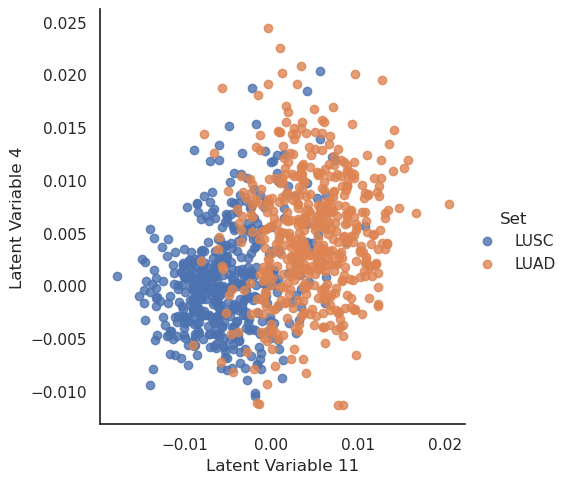

In [30]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
transformed_patients = pd.DataFrame(data=z,columns=[f"Latent Variable {ix+1}" for ix in range(latent_dim)],index=list(lusc.columns) + list(luad.columns))
transformed_patients["Set"]= (["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns])

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")

lm = sns.lmplot(x="Latent Variable 11",y="Latent Variable 4", hue='Set', data=transformed_patients, fit_reg=False)


Here we see a good, but not perfect, separation of the patients based on two latent variables.

## Using the Decoder for generating example data

Further, we can use the network to generate "typical" expression profiles. We have marked the means of each sample group with black triangles. We will now take the mean latent vectors of each patient group and feed these values to the VAE's decoder.

In [31]:
z_fix = torch.tensor(np.concatenate(([means["LUSC"]],[means["LUAD"]]), axis=0))
z_fix = z_fix.to(device)
x_fix = model.decode(z_fix).cpu().detach().numpy()
predicted = pd.DataFrame(data=x_fix.T, index=combined_reduced.index, columns=["LUSC", "LUAD"])

Using these generated profiles we may, for instance, identify the genes most differentially expressed between the generated LUSC and LUAD profiles.

In [32]:
predicted["diff"] = predicted["LUSC"] - predicted["LUAD"]
# predicted.sort_values(by='diff', ascending=False, inplace = True)

The genes that the decoder finds most different between the set means can now be identified. First the gene with the largest positive difference between LUSC and LUAD:

In [33]:
predicted["diff"].idxmin(axis=0)

'MAL'

and then in the negative direction (larger in LUAD than LUSC).

In [34]:
predicted["diff"].idxmax(axis=0)

'APOC2'